In the final stage of **TikTok Claim Classification** project, we will build **Random Forest** and **XGBoost** models to classify videos based on their **`claim_status`**. Our aim is to determine whether a video contains a **claim** or an **opinion**. Previously, we completed **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/eda-for-tiktok-claim-classification)**, **[Hypothesis Testing](https://www.kaggle.com/code/lekhatopil/two-sample-t-test-chi-squared-test-for-tiktok)**, and a **[Logistic Regression model](https://www.kaggle.com/code/lekhatopil/logistic-regression-model-for-tiktok)**.

# **Background on the TikTok Scenario**
TikTok users have the ability to submit reports that identify videos and comments that contain user claims. These reports identify content that needs to be reviewed by moderators. The process generates a large number of user reports that are challenging to consider in a timely manner. TikTok is working on the development of a predictive model that can determine whether a video contains a claim or offers an opinion.

# **Project Goal**
Develop a machine learning model to classify videos based on whether they contain **claims** or **opinions**. By implementing an accurate prediction model, TikTok aims to streamline the user report process, reduce backlog, and enhance prioritization of content moderation tasks.

# **Project Background**
* We began by cleaning the data, removing null values and checking for duplicates, followed by creating a new feature and examining its data distribution for potential trends.

* After selecting relevant features and encoding categorical variables, we split the dataset into **Train (60%)**, **Validation (20%)**, and **Test (20%)** sets.

* Text-based data was transformed into numeric form using **CountVectorizer**. Subsequently, **Random Forest** and **XGBoost** models were constructed, evaluated their performance on the validation set, and assessed the champion model on the test set using performance metrics and a confusion matrix.

This project is part of the Google Advanced Data Analytics program, and the dataset used is curated by Google as part of this program.

### **Before proceeding, let's address some important questions:**
# **What metric should we use to evaluate success of the business/organizational objective?**

## **Business Need and Modeling Objective**
TikTok users can report videos they believe violate the platform's terms of service. Given the high volume of videos created and viewed daily, it is impractical for human moderators to review each reported video individually.

* Our **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/eda-for-tiktok-claim-classification)** revealed that videos labeled as **“claim”** have a higher proportion of banned and under review statuses compared to videos labeled as **“opinion”**.

* This suggests that videos presenting **claims** are more likely to violate the terms of service than those expressing **opinions**. Therefore, distinguishing between **claim** and **opinion** videos is crucial.

* Videos identified as **opinions** are less likely to require human moderation. In contrast, videos identified as **claims** will undergo further sorting by a downstream process to determine their review priority.

* Videos will be ranked based on the number of times the video was reported, and then the most reported videos will be reviewed by human moderators each day.

## **Modeling Design & Target Variable**

* Our target variable is **`claim_status`**, with two categories: **claim** and **opinion**. We are undertaking a classification task to predict this **binary outcome**, determining whether a video is a **claim** or an **opinion**.

# **What are the ethical implications of the model? What are the consequences of the model making errors?**
1. **What is the likely effect of the model when it predicts a false negative (i.e., when the model says a video does not contain a claim and it actually does)?**

 * The likely effect of this error is that the video will not be flagged for further review, and TikTok might fail to take appropriate action against videos that potentially violate the platform's terms of service.

 * This can lead to harmful or misleading content remaining on the platform, potentially affecting and damaging the platform's reputation.

2. **What is the likely effect of the model when it predicts a false positive (i.e., when the model says a video does contain a claim and it actually does not)?**

 * The likely effect of this error is that the video will be unnecessarily flagged for human review. This can cause some inconvenience to the review system, leading to a waste of resources as reviewers spend time on non-violating content.

 * However, this scenario is generally less problematic compared to false negatives, as it primarily results in inefficiency rather than allowing harmful content to remain unaddressed.

Minimizing false negatives is more important than minimizing false positives, as false negatives can harm the platform's reputation. Therefore, our primary model evaluation metric will be **recall**, which focuses on minimizing false negatives.




# **Import Necessary Packages & Load Data**
     

In [6]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for text preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Import packages for modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
# Read Data
df = pd.read_csv('tiktok_dataset.csv', encoding = 'unicode_escape')

In [8]:
# Display Data
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [9]:
df.shape

(19382, 12)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


# **Drop Missing Values**

In [11]:
# Check missing values
df.isnull().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [12]:
# Drop rows with missing values
df = df.dropna(axis=0)

# Check data dimension after removing missing values
df.shape

(19084, 12)

# **Check Duplicate Records**

In [13]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

We removed **298** rows with missing values, which is **1.53%** of the data. Now, we have **19,084** rows with **12** columns and there are no duplicate records.

# **Data Distribution for Claim Status**

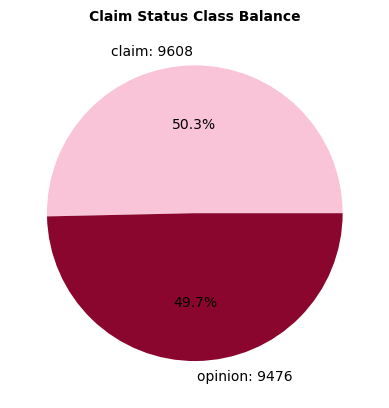

In [63]:
# Calculate the numbers of videos with claims and opinions and store in `claim_status`
claim_status = df['claim_status'].value_counts()

# Set color palette
colors = ["#F9C4D7", "#8B062E"] 
# Create a pie chart
plt.pie(claim_status, labels=[f'{claim_status.index[0]}: {claim_status.values[0]}',
                              f'{claim_status.index[1]}: {claim_status.values[1]}'],
                      autopct='%1.1f%%', colors=colors)
plt.title('Claim Status Class Balance', size=10, weight='bold');

The data is approximately balanced between the two groups, **"claim"** and **"opinion"**. Specifically, **50.3%** of the videos are labeled as **"claim"** and **49.7%** are labeled as **"opinion"**. Therefore, there is no need for upsampling the data.


# **Feature Engineering**
* Our next step will be to create a new feature named **"text_length"**, which will represent the length of characters in the **`video_transcription_text`**.

* We will then calculate the mean of this new feature and create a histogram to represent both groups (**`claim_status`**) to understand the distribution and identify if there is any clear distinction between them.

* If a significant difference exists, we will include **"text_length"** in our model; otherwise, we will exclude it.

In [15]:
# Create `text_length` column
df['text_length'] = df['video_transcription_text'].str.len()

# Display data
df[['video_transcription_text', 'text_length']].head()

,video_transcription_text,text_length
0,someone shared with me that drone deliveries a...,97
1,someone shared with me that there are more mic...,107
2,someone shared with me that american industria...,137
3,someone shared with me that the metro of st. p...,131
4,someone shared with me that the number of busi...,128


## **Calculate the average text_length for claims and opinions**

In [16]:
# Calculate the average text_length for both group
df.groupby('claim_status')['text_length'].mean()

claim_status
claim      95.570358
opinion    82.925390
Name: text_length, dtype: float64

* The mean **`text_length`** suggests that, on average, text associated with videos labeled as **claims** tends to be **13** characters longer than text associated with videos labeled as **opinions**.

## **Visualize the Distribution of text_length for Claims and Opinions**

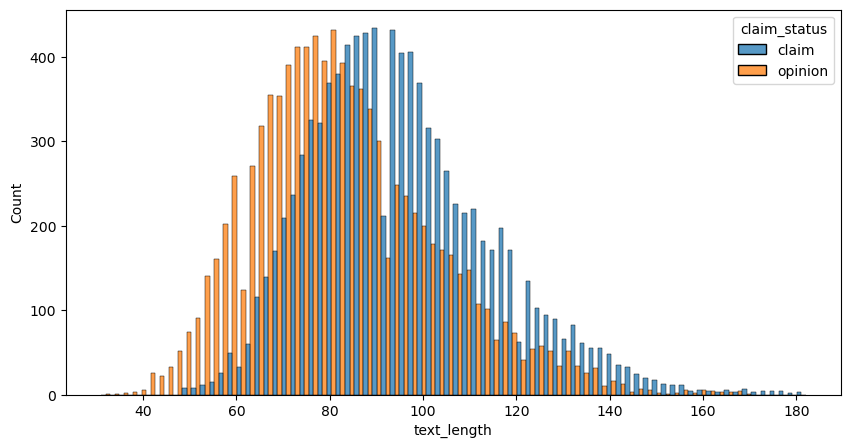

In [17]:
# Visualize the distribution of `video_transcription_text` length for claims and opinions
# Create two histograms in one plot
plt.figure(figsize = (10, 5))
sns.histplot(data=df, x='text_length',
             hue='claim_status', multiple='dodge');

The histogram shows that the distribution of **`text_length`** for both classes, **"claim"** and **"opinion"**, is approximately normal with a slight right skew. Here are the key observations:

* The distribution of **`text_length`** for **opinion** videos is generally shifted towards **lower values** compared to **claims**.

* The distribution of **`text_length`** for **claim** videos is shifted towards **higher values** compared to **opinions**.

* Videos labeled as **claims** have a broader distribution with a higher peak around **90 to 100** characters, whereas **opinion** videos have a peak around **70 to 80** characters.

The clear distinction in the **`text_length`** distribution and the significant difference in the mean of **`text_length`** indicate that this feature could be a strong predictor. Incorporating **`text_length`** into the model may enhance its ability to classify videos accurately.

# **Feature Selection and Transformation**
* For our predictor variables, we will drop variables that are of no use. We have two categorical independent variables: **`verified_status`** and **`author_ban_status`**.

* We will encode them using the **`pd.get_dummies()`** function with the parameter **`drop_first=True`**.

* Our target variable is **`claim_status`**, which has two groups: **`claim`** and **`opinion`**. Currently, it is in a categorical type, so we need to convert it into a binary outcome.

* To do this, we will create a new variable named **`claim_status1`** using the **`np.where()`** function, where **1** represents **"claim"** and **0** represents **"opinion"**.

In [18]:
# Create a copy
X = df.copy()

# Drop unnecessary columns
X = X.drop(['#', 'claim_status', 'video_id'], axis=1)

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [58]:
X.tail()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
19079,49,in our opinion the earth holds about 11 quinti...,6067.0,423.0,81.0,8.0,2.0,65,False,False,False
19080,23,in our opinion the queens in ant colonies live...,2973.0,820.0,70.0,3.0,0.0,66,False,False,False
19081,50,in our opinion the moon is moving away from th...,734.0,102.0,7.0,2.0,1.0,53,False,False,False
19082,8,in our opinion lightning strikes somewhere on ...,3394.0,655.0,123.0,11.0,4.0,80,False,False,False
19083,58,in our opinion a pineapple plant can only prod...,5034.0,815.0,281.0,11.0,1.0,70,False,False,False


In [19]:
# Create binary `claim_status1` column
df['claim_status1'] = np.where(df['claim_status'] == 'claim', 1, 0)

# Check
df[['claim_status', 'claim_status1']].head()

,claim_status,claim_status1
0,claim,1
1,claim,1
2,claim,1
3,claim,1
4,claim,1


In [20]:
# Isolate y variable
y = df['claim_status1']

# **Outliers & Multicollinearity in Tree-Based Models**

* Tree-based models like **Random Forest** and **XGBoost** are known for their robustness to outliers and multicollinearity.

* They can effectively handle extreme values and correlated predictors without significant impact on performance. As a result, we will proceed without removing outliers or addressing multicollinearity concerns.


# **Split the Data: Train/Validation/Test Sets (60/20/20)**

* First, we will split the data into an **interim training set** and **test set** using an **80/20** ratio. Then, we will further split the **interim training set** into a **training set** and a **validation set** using a **75/25** ratio. This results in a final ratio of **60/20/20** for the training, validation, and test sets.

In [21]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

# **Tokenize Text Column**
* In the TikTok dataset, we have a text-based feature **`video_transcription_text`**, and we want to extract numerical features from it. One possible way to do this is through a **bag-of-words** algorithm like **CountVectorizer**.

* **CountVectorizer** is a technique used in **Natural Language Processing (NLP)** that transforms **text data** into **numerical data**.

* **CountVectorizer** works by splitting text into **n-grams**, which are groups of **n consecutive words**. Splitting text into **n-grams** is an example of **tokenization**.

* **Tokenization** is the process of breaking text into smaller units to derive meaning from the resulting tokens. This transformation allows **text data** to be used as input for machine learning algorithms.


In [22]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range = (2, 3),
                            max_features = 15,
                            stop_words = 'english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

## **Fit the Vectorizer to the Training Data**
**Fitting and Transforming:** For the training data, we fit the **CountVectorizer** to learn the vocabulary and then transform the text into numerical features.

In [23]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True),
                           count_df], axis=1)

# Display
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,61,False,False,False,...,0,0,0,0,0,0,0,0,0,0


# **Transform the Vectorizer to the Validation Data**
**Transforming Only:** For the **validation** and **test sets**, we use the already learned vocabulary to transform the text into numerical features. We will not refit the **CountVectorizer** to the validation and test sets; we will only transform these sets to ensure consistency across datasets.


In [26]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True),
                         validation_count_df], axis=1)

# Display
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


# **Transform the Vectorizer to the Test Data**

In [29]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
test_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Concatenate `X_test` and `test_count_df` to form the final dataframe for training data (`X_test_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True),
                          test_count_df], axis=1)

X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,74,False,False,False,...,0,0,0,0,0,0,0,0,0,0


# **Build a Random Forest Model**

In [34]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             'n_estimators': [75, 100, 200]
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [35]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 5min 22s, sys: 11 s, total: 5min 33s
Wall time: 5min 49s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [36]:
# Examine best recall score
rf_cv.best_score_

np.float64(0.9948229743644765)

In [37]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

# **Build an XGBoost Model**

In [41]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4, 8, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [42]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 3min 53s, sys: 1min 53s, total: 5min 46s
Wall time: 1min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [43]:
# Examine best recall score
xgb_cv.best_score_

np.float64(0.9898176171763818)

In [44]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

# **Evaluate Model Performance on Validation Test**

## **Random Forest**

In [45]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

# **Confusion Matrix to Visualize the Results of the Random Forest Classification Model**

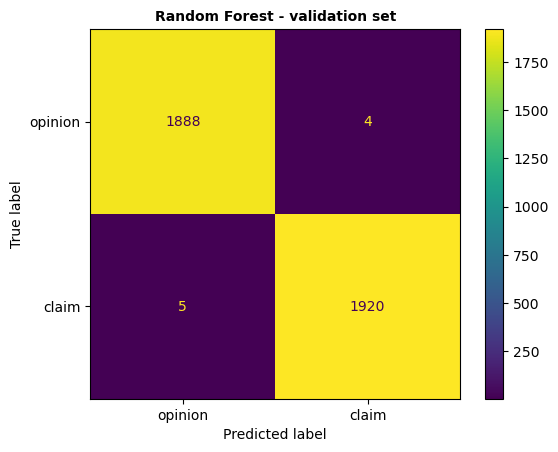

In [46]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred, labels=rf_cv.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=['opinion', 'claim'])

# Plot confusion matrix
log_disp.plot()

# Add Title
plt.title('Random Forest - validation set', size=10, weight='bold');

In [47]:
rf_cv.classes_

array([0, 1])

# **Create a Classification Report for Random Forest**


In [49]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



* The precision, recall, F1-score, and accuracy on the validation set are all **1.0**, indicating perfect performance on this set. During the cross-validation process, the **best mean recall score** achieved was **0.99**, which is very close to **1.0**.

* This high cross-validation recall score suggests that the model performs consistently well across different subsets of the training data.

## **Misclassification**

* The confusion matrix for the validation set shows **10 misclassifications**, indicating that while the model performs exceptionally well, there are still a few instances where it makes errors.

* Despite these few misclassifications, the overall performance remains outstanding, with near-perfect precision, recall, and F1-scores.

These results indicate that the model generalizes well to unseen data, with no significant drop in performance from cross-validation to validation, suggesting it is neither overfitting nor underfitting.


# **Confusion Matrix to Visualize the Results of the XGBoost Classification Model**

In [50]:
# Evaluate XGBoost model on validation set
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

# Display
y_pred

array([1, 0, 1, ..., 1, 1, 1])

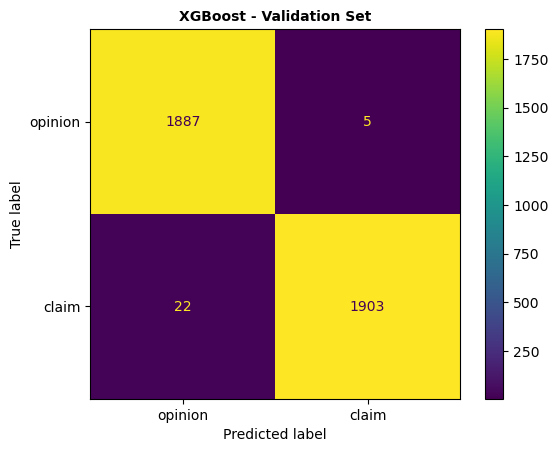

In [51]:
# Compute values for confusion matrix for xgboost - validation set
log_cm = confusion_matrix(y_val, y_pred, labels=xgb_cv.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=['opinion', 'claim'])

# Plot confusion matrix
log_disp.plot()

# Add title
plt.title('XGBoost - Validation Set', size=10, weight='bold');

In [52]:
# Create a classification report for xgboost - validation set
target_labels = ['opinion', 'claim']

print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



Since our target class of interest is **"claim"**, the performance metrics for this class are particularly important. Here’s a detailed interpretation:

* The recall score of **0.99** indicates that the model successfully identified **99%** of the videos labeled as **"claim"**. This is crucial in our classification task because missing a **claim** could have **significant consequences.**

* The precision score of **1.00** means that every video predicted as a **"claim"** by the model is indeed a **"claim"**.

* The **F1-score** of **0.99** combines precision and recall, reflecting the model's excellent overall performance in identifying claims.

* The **best mean recall score** of **0.9898**, close to **1.00**, along with the validation set recall score of **1.00**, indicates that the model consistently performs well in identifying **true positives**.


## **Misclassification**
According to the confusion matrix, the model made a total **of** **26 misclassifications**.

* **False Negatives (FN):** **22** instances where **claims** were incorrectly classified as **opinions**.

* **False Positives (FP)**: Only **4** instances where **opinions** were incorrectly classified as **claims**.

# **Model Comparison**
While the **XGBoost model** demonstrates strong performance with high precision, recall, and F1-scores for the **"claim"** class, it was slightly outperformed by the **Random Forest model** in terms of recall and F1-score. The **Random Forest model** achieved a marginally higher recall and F1-score.


# **Champion Model to Predict on Test Data**
Although the **XGBoost model's** performance metrics reflect its strong capability to accurately classify the data, the **Random Forest model** outperforms it in key metrics for our target class.

Therefore, our champion model will be the **Random Forest model** due to its slightly higher recall and F1-score for the **"claim"** class.

In [53]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

y_pred

array([1, 0, 1, ..., 0, 1, 0])

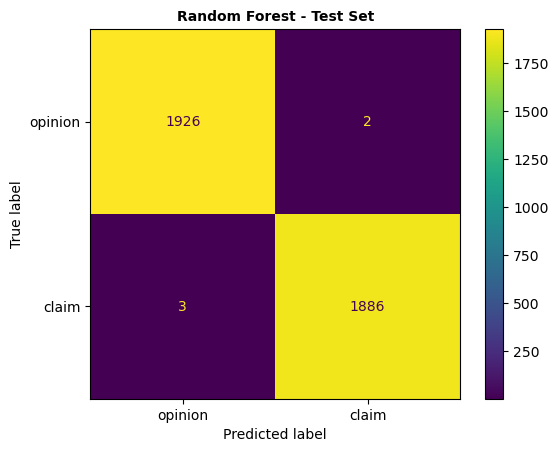

In [54]:
# Compute values for confusion matrix - Random forest test data
log_cm = confusion_matrix(y_test, y_pred, labels=rf_cv.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=['opinion', 'claim'])

# Plot confusion matrix
log_disp.plot()

# Add title
plt.title('Random Forest - Test Set', size=10, weight='bold');

In [55]:
# Create a classification report - Random forest test set
target_labels = ['opinon', 'claim']

print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

      opinon       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



* The evaluation of the Random Forest model on the test set shows exceptional performance, with perfect precision, recall, and F1-scores for classifying the videos as claims or opinions.

* The identical performance scores on both the validation and test sets demonstrate the model's robustness and consistency, suggesting it generalizes well to new and unseen data.

**The confusion matrix indicates a total of 5 misclassifications:** **2** false positives and **3** false negatives. This indicates that a very small number of **claims** are being missed.

## **Overall Interpretation**

The **Random Forest model** is highly effective for the claim classification task, achieving near-perfect performance metrics.

Despite a very small number of misclassifications, the model's precision, recall, and F1-scores of **1.00** underscore its reliability and accuracy.

Therefore, the **Random Forest model** proves to be a great choice for the TikTok claim classification project.



# **Feature Importances of Champion Model - Random Forest**

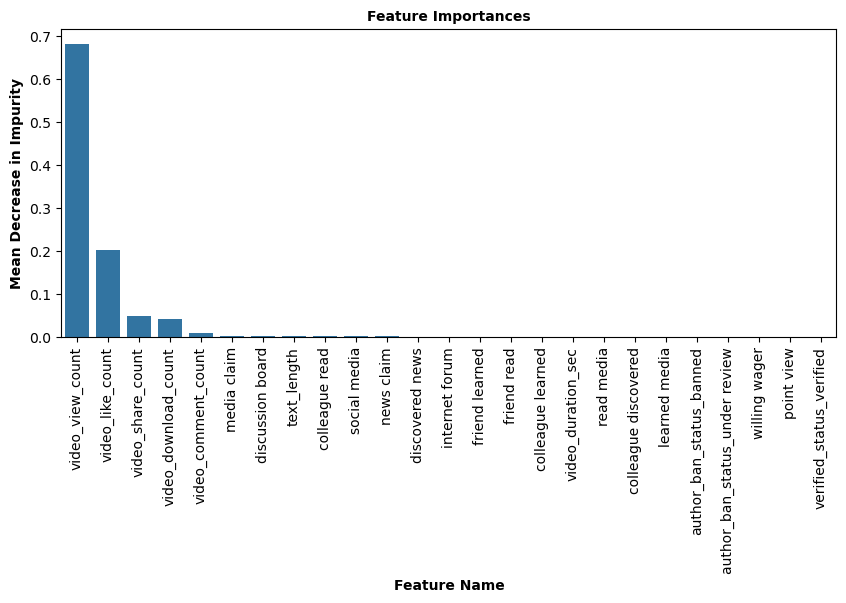

In [56]:
# Extract the importances
importances = rf_cv.best_estimator_.feature_importances_

# Create a dataframe
importances_df = pd.DataFrame(data={'Feature Name': rf_cv.feature_names_in_,
                                    'Importance': importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Create a feature importance bar plot
plt.figure(figsize=(10, 4))
sns.barplot(data=importances_df, x='Feature Name', y='Importance')
plt.xlabel('Feature Name', size=10, weight='bold')
plt.ylabel('Mean Decrease in Impurity', size=10, weight='bold')
plt.xticks(rotation=90)
plt.title('Feature Importances', size=10, weight='bold');

In [57]:
importances_df

,Feature Name,Importance
0,video_view_count,0.683238
1,video_like_count,0.201654
2,video_share_count,0.049791
3,video_download_count,0.041496
4,video_comment_count,0.008204
5,media claim,0.002446
6,discussion board,0.002015
7,text_length,0.001438
8,colleague read,0.001318
9,social media,0.001160


* From the feature importance analysis, it is evident that the **`video_view_count`** variable emerges as the most influential predictor for classifying the videos as **claims** or **opinions**.

* The feature importance (measured as the mean decrease in impurity) for **`video_view_count`** is the highest among all features, suggesting it has the strongest influence on the classification.

* Our **[Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/lekhatopil/eda-for-tiktok-claim-classification)** on this dataset indicated that engagement metrics such as **views, likes, comments, shares, and downloads** are associated with videos labeled as **claims**. The feature importance analysis further supports this finding, revealing that the top five most important features are all engagement metrics.

# **Conclusion**
The **Random Forest model** identifies **`video_view_count`** as the most critical feature for classifying videos, followed by **`video_like_count`** and **`video_share_count`**. This indicates a **positive correlation** between higher engagement metrics (such as more likes, shares, and comments) and videos labeled as **claims** on TikTok.

However, it's important to remember that **correlation** does not imply **causation**. Other factors might also play significant roles. For instance, videos labeled as **claims** could naturally attract more attention due to their controversial or thought-provoking nature.

# **Questions**

## **Would you recommend using this model?**
**Yes**, I would recommend using this model.

Both the **Random Forest** and **XGBoost** models performed exceptionally well on both the validation and test sets. The precision, recall, F1, and accuracy scores were consistently high for both models, with very few misclassifications.

However, the Random Forest model had a slight edge over the XGBoost model. The recall and F1-score for the Random Forest model were both **1.00**, compared to **0.99** for the XGBoost model. Given this slight improvement, we recommend using the Random Forest model.

The Random Forest model has demonstrated its ability to correctly classify videos as **claims** or **opinions** and is expected to generalize well to new and unseen data. Therefore, Random Forest model is the preferred choice for the TikTok classification task.

## **What was your model doing? Can you explain how it was making predictions?**
The model was classifying the videos based on user engagement metrics. Specifically, the model considered the number of views, likes, shares, comments, and downloads each video received. These engagement metrics were the most predictive features, with **`video_view_count`** being the most influential.

### **How was the model making predictions?**
* The **Random Forest model** is an **ensemble method** that makes predictions by **building multiple decision trees** during training.
* Each decision tree is created using a random subset of features and data. The final classification for each video is based on the **majority vote** from all the trees.

Overall, the Random Forest model demonstrated exceptional performance with perfect scores across all metrics. This indicates a highly accurate and reliable model that can effectively classify videos as either **claims** or **opinions**.

## **What features would you want to have that would likely improve the performance of your model?**
Our champion model, **Random Forest**, is currently performing exceptionally well, with scores nearly perfect. Thus, there might not be an immediate need for new features to improve its performance.

However, to gain a deeper understanding of the dataset and potentially enhance the model further, considering additional features could be beneficial.

### **Potential Additional Features:**
* **Category of the Video:** Knowing the category of each video would be beneficial, as certain categories might be more likely to contain **claims** or **opinions**.

* **Number of Times the Video Was Reported:** This feature could indicate controversial content, which might correlate with the likelihood of a video being a **claim**.

While the model's current performance is excellent, exploring these additional features could offer new insights. Even if these features do not significantly enhance predictive performance, they can provide valuable context and contribute to a more comprehensive analysis of the dataset. It is important to continuously explore and understand the dataset to maintain and improve the model's effectiveness over time.
